In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.datasets

In [24]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


In [25]:
X_train = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
X_test = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

In [26]:
#normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# size of the layers
l1 = 1024
l2 = 128


In [7]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, 10)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [8]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [78]:
#initialize lists

EPOCHS  = 50

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
    
    
    
    w1 = model.layer1.weight
    b1 = model.layer1.bias

    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    k = k+1
   
accuracy_list

  2%|▏         | 1/50 [00:07<06:21,  7.79s/it]

Epoch 0: Loss 1.60113525390625, Accuracy 0.8540999889373779


 12%|█▏        | 6/50 [00:43<05:20,  7.28s/it]

Epoch 5: Loss 1.5988787412643433, Accuracy 0.8557000160217285


 22%|██▏       | 11/50 [01:18<04:30,  6.95s/it]

Epoch 10: Loss 1.5970122814178467, Accuracy 0.8578000068664551


 32%|███▏      | 16/50 [01:52<03:54,  6.91s/it]

Epoch 15: Loss 1.5952856540679932, Accuracy 0.8590999841690063


 38%|███▊      | 19/50 [02:23<03:53,  7.53s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

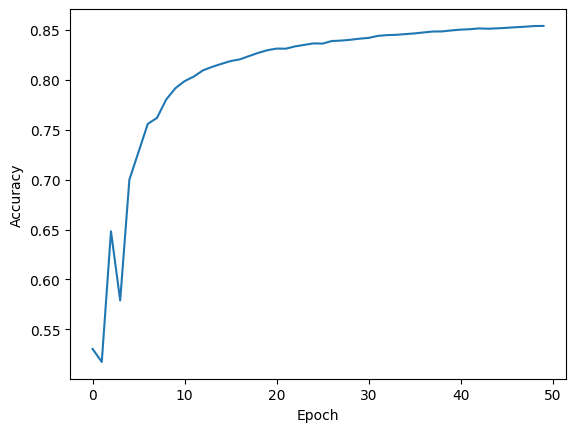

In [11]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [37]:
X_train.shape

torch.Size([60000, 784])

In [38]:
X_test.shape

torch.Size([10000, 784])

In [77]:
est_alpha_kd = mcbe.dd_mcbe(np.array(weights)[-1], X_train, num_estimation_points=10000, dd_method="blowup")

In [66]:
est_alpha_kd = mcbe.dd_mcbe(np.array(weights)[-1], X_train, num_estimation_points=100000, dd_method="kde")
print("done")
percent_inj_kd = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_kd, points=X_test[:1000,:],iter=X_test.shape[0])
percent_inj_kd

  1%|          | 683/100000 [00:10<25:06, 65.92it/s]


KeyboardInterrupt: 

In [21]:
num_iter = 10
num_estimation_points = 100000

inj_kd = []
inj_rd = []
inj_blowup = []
inj_mcbe = []
inj_og = []
inj_small_bias = []

for i in tqdm.tqdm(range(num_iter)):

    #kernel density estimation
    est_alpha_kd = mcbe.dd_mcbe(np.array(weights)[-1], X_train, num_estimation_points, dd_method="kd")
    percent_inj_kd = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_kd, points=X_test,iter=X_test.shape[0])
    inj_kd.append(percent_inj_kd)

    #blown up data
    est_alpha_blowup = mcbe.dd_mcbe(np.array(weights)[-1], X_train,  num_estimation_points, dd_method="blowup")
    percent_inj_blowup = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_blowup, points=X_test,iter=X_test.shape[0])
    inj_blowup.append(percent_inj_blowup)

    #mcbe
    est_alpha = mcbe.mcbe(polytope=np.array(weights)[-1],N=num_estimation_points,distribution="normal",radius=np.max(np.array(X_train)), sample_on_sphere=False)
    percent_inj = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha, points=X_test,iter=X_test.shape[0])
    inj_mcbe.append(percent_inj)


    



    

  0%|          | 0/10 [00:00<?, ?it/s]

kernel done
blowup done


  0%|          | 0/10 [12:10<?, ?it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'percent of injectivity on test set for differnet bias estimation methods')

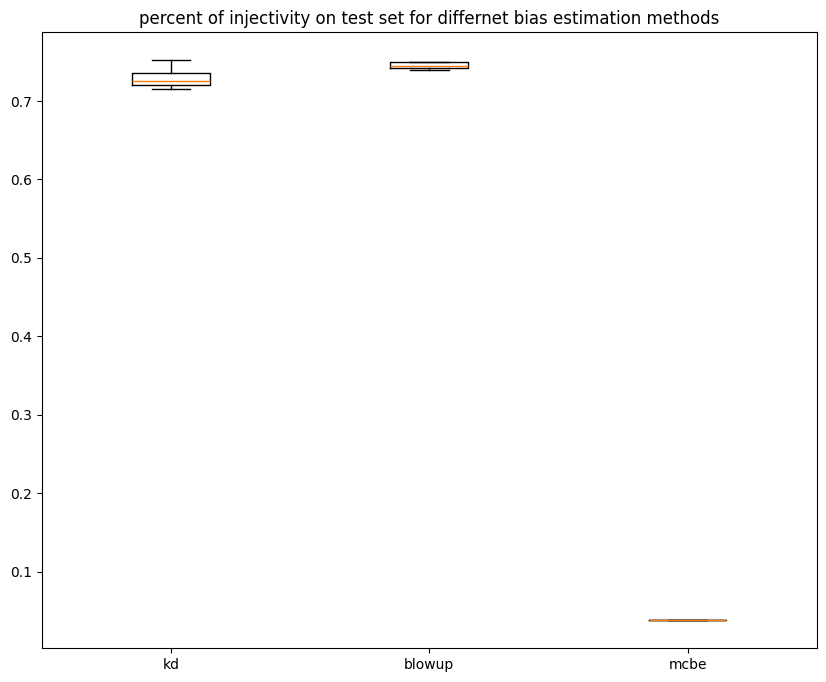

In [ ]:
#compare inj lists in boxplots
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.boxplot([inj_kd,inj_blowup,inj_mcbe],labels=["kd","blowup","mcbe"])
plt.title("percent of injectivity on test set for differnet bias estimation methods")

In [ ]:
inj_mnist = pd.DataFrame({"kd":inj_kd,"blowup":inj_blowup,"mcbe":inj_mcbe})
inj_mnist.to_csv("inj_mnist.csv")